In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import docker
from io import StringIO
import os.path

# Import one methods from other file
from dl_routines import *


client = docker.from_env()
client.containers.list()
container=client.containers.get("datalab_s22")
container.attach()

path="../code/assignment/"

t=180
dt=1/4096
N=180/dt
sigma=25

filename = "data_03.csv"

Plot the signal

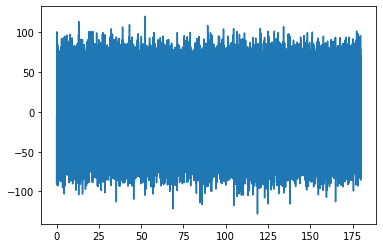

In [2]:
data=pd.read_csv(path+filename,delimiter=' ',header=None)
plt.plot(data[0],data[1])

***First analysis***

at first do a analysis with method 3 fourier transformation because it is best for easy signals

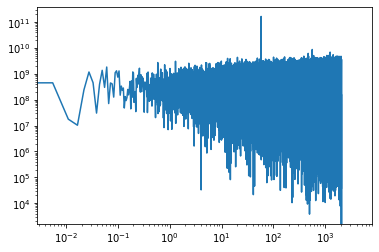

In [3]:
df_m3 = method_three(filename)
plt.plot(df_m3[0],df_m3[2])
plt.xscale("log")
plt.yscale("log")
plt.show()

Get the frequency stepsize from the fourier sprectrum

In [4]:
dfreq = df_m3[0][1]-df_m3[0][0]
dfreq

0.00555648

Get an overview over the range where the maximum peak lays

In [5]:
df_m3_sort = df_m3.sort_values(by=[2],ascending=False)
df_m3_sort

,0,1,2
10434,57.9763,0,1.643130e+11
10435,57.9819,0,8.987310e+10
10433,57.9708,0,1.715010e+10
10436,57.9874,0,9.968800e+09
100867,560.4650,0,8.685920e+09
...,...,...,...
491517,2731.1000,0,0.000000e+00
491516,2731.1000,0,0.000000e+00
491515,2731.0900,0,0.000000e+00
491514,2731.0900,0,0.000000e+00


In [6]:
df_m3.loc[10424:10444]

,0,1,2
10424,57.9207,0,5.910440e+08
10425,57.9263,0,1.310390e+09
10426,57.9319,0,1.760740e+09
10427,57.9374,0,6.049060e+08
10428,57.9430,0,8.076590e+07
10429,57.9485,0,1.398540e+09
10430,57.9541,0,1.719020e+09
10431,57.9596,0,5.509290e+08
10432,57.9652,0,5.482180e+09
10433,57.9708,0,1.715010e+10


The biggest frequeny is very clear so i just choose one

In [7]:
freq  = df_m3[0][df_m3[2].idxmax(0)]
freq

57.9763

***Templatebank and probing***

create template bank in range of the just determined frequency

because there is only one possible frequency intervall we can directly make the runtime analysis
We do a square of:

In [8]:
freqs = int(2*dfreq/1.1e-4)
phis = 131
createTemplateBank(filename,freqs,freq-dfreq,freq+dfreq,phis)
freqs * phis

13231

Runtime analysis

Take the time for probing of one element of the template bank

In [9]:
%%timeit -n100 -r3
prober(filename,method=1,freq_prober=freq,phi=0)

433 ms ± 9.44 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)


thus we expect a runtime of:

In [10]:
print(freqs * phis * 0.235 / 60, "minutes")

51.821416666666664 minutes


which from experience is way to high. It is probably because of the time it take to call the function and the reason that prober with a template bank is way more optimised.

do an analysis for frequency, phase and amplitude with method 1 scalar product (takes about 3-4 min):

In [11]:
%%time
prober_tb(filename,1,filename)

CPU times: user 14.4 ms, sys: 22.2 ms, total: 36.5 ms
Wall time: 3min 25s


ExecResult(exit_code=0, output=b'')

visualize the result

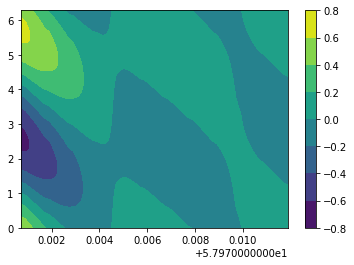

(57.9707, 5.7032, 1.289064)

In [12]:
df = proberToDf(filename,True)
(a ,b)  = (df[0].drop_duplicates(),df[1].drop_duplicates())
plt.contourf(a,b,df[2].values.reshape(len(b.index),len(a.index)))
plt.colorbar()
plt.show()
idmax = df[2].idxmax()
freq = df[0][idmax]
phase = df[1][idmax]
ampl = df[2][idmax]*2
(freq,phase,ampl)

the solution seems very plausible and is very sharp

Dataframe of (df, dphi, mismatch)_i

In [13]:
mismatch=1-df[2]/ampl*2
d = {'df': np.abs(df[0]-freq), 'dp':np.abs(df[1]-phase),'mismatch':mismatch}
mismatch = pd.DataFrame(data=d)
mismatch

,df,dp,mismatch
0,0.0000,5.70320,0.156295
1,0.0002,5.70320,0.209357
2,0.0003,5.70320,0.264674
3,0.0004,5.70320,0.321657
4,0.0005,5.70320,0.379834
...,...,...,...
13226,0.0107,0.57999,0.835119
13227,0.0108,0.57999,0.829850
13228,0.0109,0.57999,0.825928
13229,0.0110,0.57999,0.823630


***ROC curve***

Generate Noise and multiple signals with above parameters

In [14]:
for i in range(0,100):
    if not os.path.isfile(path+getFileName(N,sigma,0,deltaT=dt)+"_"+str(i)):
        filename = getFileName(N=N,sigma=sigma,amplitude=0,deltaT=dt)+"_"+str(i)
        generate_source(N=N,sigma=sigma,amplitude=0,deltaT=dt,filename=filename)
        
for i in range(0,100):
    if not os.path.isfile(path+getFileName(N,sigma,ampl,freq,deltaT=dt,phase=phase)+"_"+str(i)):
        filename = getFileName(N=N,sigma=sigma,amplitude=ampl,freq=freq,deltaT=dt,phase=phase)+"_"+str(i)
        generate_source(N=N,sigma=sigma,amplitude=ampl,freq=freq,deltaT=dt,phase=phase,filename=filename)

probe the generated signals

In [15]:
probeN=[float(method_one(getFileName(N,sigma,0,deltaT=dt)+"_"+str(i),freq,phase)[2])/ampl*2 for i in range(0,100)]
probeS=[float(method_one(getFileName(N,sigma,ampl,freq,dt,phase)+"_"+str(i),freq,phase)[2])/ampl*2 for i in range(0,100)]

In [16]:
ampl

1.289064

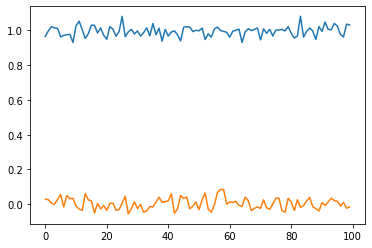

In [17]:
plt.plot(probeS)
plt.plot(probeN)
plt.show()

Plot histograms

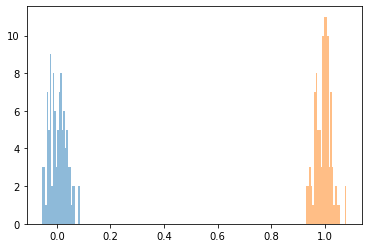

In [18]:
plt.hist(probeN,bins=25,alpha=0.5)
plt.hist(probeS,bins=25,alpha=0.5)
plt.show()

Generate ROC curve

In [19]:
roc = compute_thresholds(probeS,probeN)
roc

,threshold,false positives,true positives
0,-1.000000,100,100
1,-0.979798,100,100
2,-0.959596,100,100
3,-0.939394,100,100
4,-0.919192,100,100
...,...,...,...
95,0.919192,0,100
96,0.939394,0,96
97,0.959596,0,90
98,0.979798,0,68


Plot the roc curve and get the threshold.

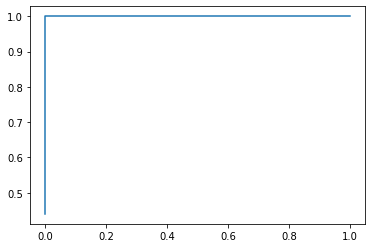

0.9595959595959598

In [20]:
roc_curve(probeS,probeN)

With this threshold about 90/100 times the signal gets detected, while 0/100 times noise gets detected as a signal.

In [21]:
roc[97:98]

,threshold,false positives,true positives
97,0.959596,0,90
